<a href="https://colab.research.google.com/github/HeNeos/Reports-FIM-UNI/blob/master/MC516-C%C3%A1lculo%20por%20elementos%20finitos/PC%205/MC516_PC5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Librerías

In [395]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
#path = '/content/drive/My Drive/Colab Notebooks/MC516/PC5/'

# Funciones


In [396]:
def NaiveMultiply(A,B):
    C = np.zeros((A.shape[0],B.shape[1]))
    for i in range(0,C.shape[0]):
        for j in range(0,C.shape[1]):
            aux = 0
            for k in range(0,A.shape[1]):
                aux += A[i][k]*B[k][j]
            C[i][j] = aux
    return C
 
def nextPowerofTwo(n):
    return int(2**(ceil(log2(n))))
 
def ModifyMatrix(A):
    newA = A
    if(A.shape[1]%2 == 1):
        aux = np.zeros((A.shape[0],A.shape[1]+1))
        aux = np.insert(A,A.shape[1],0,axis=1)
        newA = aux
    if(newA.shape[0]%2 == 1):
        aux = np.zeros((newA.shape[0]+1,newA.shape[1]))
        aux = np.insert(newA,newA.shape[0],0,axis=0)
        newA = aux
    return newA
 
def FastMultiply(oldA,oldB):
    rows = oldA.shape[0]
    columns = oldB.shape[1]
    if(rows <= 2 or columns <=2 or oldA.shape[1] <= 2 or oldB.shape[0] <= 2):
        return np.matmul(oldA,oldB)
    
    A = ModifyMatrix(oldA)
    B = ModifyMatrix(oldB)
    N1 = A.shape[0]
    N2 = A.shape[1]
    N3 = B.shape[0]
    N4 = B.shape[1]
    
 
    a = A[0:N1//2,0:N2//2]
    b = A[0:N1//2,N2//2:N2//2+N2//2]
    c = A[N1//2:N1//2+N1//2,0:N2//2]
    d = A[N1//2:N1//2+N1//2,N2//2:N2//2+N2//2]
    
    e = B[0:N3//2,0:N4//2]
    f = B[0:N3//2,N4//2:N4//2+N4//2]
    g = B[N3//2:N3//2+N3//2,0:N4//2]
    h = B[N3//2:N3//2+N3//2,N4//2:N4//2+N4//2]
    
    
    p1 = FastMultiply(a,(f-h))
    p3 = FastMultiply((c+d),e)
    p2 = FastMultiply((a+b),h)
    p4 = FastMultiply(d,(g-e))
    p5 = FastMultiply((a+d),(e+h))
    p6 = FastMultiply((b-d),(g+h))
    p7 = FastMultiply((a-c),(e+f))
    
    
    C = np.zeros((rows,columns))
    
    c11 = p5 + p4 - p2 + p6
    c12 = p1 + p2
    c21 = p3 + p4
    c22 = p1 + p5 - p3 - p7
    
 
    
    for i in range(0,N1//2):
        for j in range(0,N4//2):
            C[i][j] = c11[i][j]
            if(j + N4//2 < columns):
                C[i][j+N4//2] = c12[i][j]
            if(i + N1//2 < rows):
                C[i+N1//2][j] = c21[i][j]
                if(j + N4//2 < columns):
                    C[i+N1//2][j+N4//2] = c22[i][j]
    return C

In [397]:
def conjugate_grad(A, b, x=None):
    n = b.shape[0]
    if not x:
        x = np.ones((n,1))
    r = np.dot(A, x) - b
    p = - r
    r_k_norm = FastMultiply(np.transpose(r), r)
    for i in range(2*n):
        Ap = np.dot(A, p)
        alpha = r_k_norm /FastMultiply(np.transpose(p), Ap)
        x += alpha * p
        r += alpha * Ap
        r_kplus1_norm = FastMultiply(np.transpose(r), r)
        beta = r_kplus1_norm / r_k_norm
        r_k_norm = r_kplus1_norm
        p = beta * p - r
    return x

In [398]:
NodesCondition = []
ForcesCondition = []

def UBoundaryCondition(nU,u,i):
    nU[i][0] = u
    NodesCondition.append(i)
 
def FBoundaryCondition(nF,f,i):
    nF[i][0] += f
    ForcesCondition.append(i)

def DFBoundaryCondition(nF,w,e):
    f = Elements[e][0]
    s = Elements[e][1]
    l = L[e]
    FBoundaryCondition(nF,w*l/2,2*f+0)
    FBoundaryCondition(nF,w*l*l/12,2*f+1)
    FBoundaryCondition(nF,w*l/2,2*s+0)
    FBoundaryCondition(nF,-w*l*l/12,2*s+1)

def ElementStiffness(E, I, L):
    aux = np.zeros((4,4))
    s1 = np.array([12,6*L,-12,6*L])
    s2 = np.array([6*L,4*L*L,-6*L,2*L*L])
    for i in range(0,2):
        for j in range(0,4):
            aux[2*i][j] = s1[j]
            aux[2*i+1][j] = s2[j]
            if(i == 1):
                aux[2*i][j] *= -1
    aux[3][1] = 2*L*L
    aux[3][3] = 4*L*L
    aux = aux*E*I/(L**3)
    return aux

def AssemblyStiffness(nStiffnessMatrix,k,i,j):
    for p in range(0,2):
        for m in range(0,2):
            nStiffnessMatrix[2*i+p][2*i+m] += k[p][m]
            nStiffnessMatrix[2*i+p][2*j+m] += k[p][2+m]
            nStiffnessMatrix[2*j+p][2*i+m] += k[p+2][m]
            nStiffnessMatrix[2*j+p][2*j+m] += k[p+2][2+m]
 
def Initialize(nStiffnessMatrix,nU,nF):
    for i in range(0,Nodes):
        nU[i][0] = 0
        nF[i][0] = 0
    for i in range(0,NumberOfElement):
        AssemblyStiffness(nStiffnessMatrix,K[i],int(Elements[i][0]),int(Elements[i][1]))

def PreSolvingStiffness(nStiffnessMatrix):
    nsize = Nodes-len(NodesCondition)
    newStiffness = np.zeros((nsize,nsize))
    contr = -1
    for i in range(0,Nodes):
        contc = -1
        flagr = False
        for k in range(0,len(NodesCondition)):
            if(i == NodesCondition[k]):
                flagr = True
                break
        if(flagr):
            continue
        contr += 1
        for j in range(0,Nodes):
            flagc = False
            for k in range(0,len(NodesCondition)):
                if(j == NodesCondition[k]):
                    flagc = True
                    break
            if(flagc):
                continue
            contc += 1
            newStiffness[contr][contc] = nStiffnessMatrix[i][j]
    return newStiffness
 
 
def PreSolvingF(nF,nS,nU):
    nsize = Nodes-len(NodesCondition)
    newF = np.zeros(nsize).reshape(nsize,1)
    contr = -1
    for i in range(0,Nodes):
        flagr = False
        for k in range(0,len(NodesCondition)):
            if(i == NodesCondition[k]):
                flagr = True
                break
        if(flagr):
            for k in range(0,Nodes):
                nF[k][0] = nF[k][0]-nS[k][i]*nU[i][0]
            continue
 
            
    for i in range(0,Nodes):
        flagr = False
        for k in range(0,len(NodesCondition)):
            if(i == NodesCondition[k]):
                flagr = True
                break
        if(flagr):
            continue
        contr += 1
        newF[contr][0] = nF[i][0]
    
    return newF
                      
 
def Solve(nStiffnessMatrix,nU,nF):
    newStiffness = PreSolvingStiffness(nStiffnessMatrix)
    newF = PreSolvingF(nF,nStiffnessMatrix,nU)
    u = np.linalg.solve(newStiffness,newF)
    #u = conjugate_grad(newStiffness,newF)    
    contr = -1
    for i in range(0,Nodes):
        flagr = False
        for k in range(0,len(NodesCondition)):
            if(i == NodesCondition[k]):
                flagr = True
                break
        if(flagr):
            continue
        contr += 1
        nU[i][0] = u[contr][0]
    nnF = FastMultiply(StiffnessMatrix,nU)
    return nU,nnF

# 10 Elementos

In [399]:
NodesCondition = []
Nodes = 11
Nodes *= 2
NumberOfElement = 10

E = 3e5 #MPA
K = []
I = 315e4 #mm^4
M_A = 2e5 #N-mm
PosNodes = np.array([0,100,200,300,400,500,600,700,800,900,1000])
Elements = np.array([(0,1),(1,2),(2,3),(3,4),(4,5),(5,6),(6,7),(7,8),(8,9),(9,10)])
L = []
for i in range(NumberOfElement):
    L.append(PosNodes[Elements[i][1]] - PosNodes[Elements[i][0]])
L = np.array(L)

for i in range(0,NumberOfElement):
    aux = ElementStiffness(E,I,L[i])
    K.append(aux)


StiffnessMatrix = np.zeros((Nodes,Nodes))

U = np.zeros(Nodes).reshape(Nodes,1)
F = np.zeros(Nodes).reshape(Nodes,1)

Initialize(StiffnessMatrix,U,F)

#Node in UBoundary = Node*2+(y=0,phi=1)
UBoundaryCondition(U,0,2*0+0) #Nodo 0 en Y
UBoundaryCondition(U,0,2*10+0) #Nodo 2 en Y

#DFBC(F,w,element)
#FBC(F,f,Node*2+(y=0,phi=1))
FBoundaryCondition(F,M_A,2*7+1) #Momento en el nodo 7

U,F=Solve(StiffnessMatrix,U,F)
print("Stiffness Matrix:\n",StiffnessMatrix,'\n')
print("Displacements:\n",U,'\n')
print("Forces:\n",F)

Stiffness Matrix:
 [[ 1.134e+07  5.670e+08 -1.134e+07  5.670e+08  0.000e+00  0.000e+00
   0.000e+00  0.000e+00  0.000e+00  0.000e+00  0.000e+00  0.000e+00
   0.000e+00  0.000e+00  0.000e+00  0.000e+00  0.000e+00  0.000e+00
   0.000e+00  0.000e+00  0.000e+00  0.000e+00]
 [ 5.670e+08  3.780e+10 -5.670e+08  1.890e+10  0.000e+00  0.000e+00
   0.000e+00  0.000e+00  0.000e+00  0.000e+00  0.000e+00  0.000e+00
   0.000e+00  0.000e+00  0.000e+00  0.000e+00  0.000e+00  0.000e+00
   0.000e+00  0.000e+00  0.000e+00  0.000e+00]
 [-1.134e+07 -5.670e+08  2.268e+07  0.000e+00 -1.134e+07  5.670e+08
   0.000e+00  0.000e+00  0.000e+00  0.000e+00  0.000e+00  0.000e+00
   0.000e+00  0.000e+00  0.000e+00  0.000e+00  0.000e+00  0.000e+00
   0.000e+00  0.000e+00  0.000e+00  0.000e+00]
 [ 5.670e+08  1.890e+10  0.000e+00  7.560e+10 -5.670e+08  1.890e+10
   0.000e+00  0.000e+00  0.000e+00  0.000e+00  0.000e+00  0.000e+00
   0.000e+00  0.000e+00  0.000e+00  0.000e+00  0.000e+00  0.000e+00
   0.000e+00  0.000e+00 

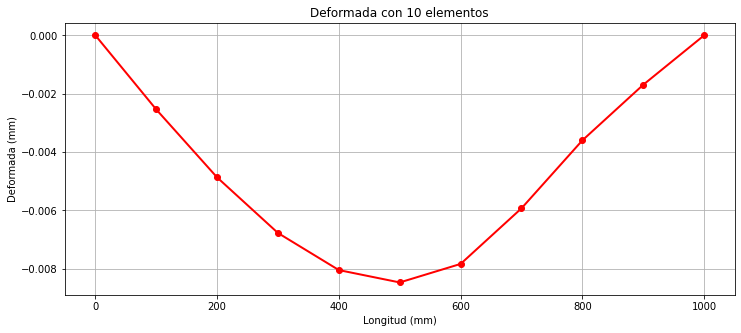

In [400]:
_ydisplacements10 = []
for i in range(int(U.shape[0]/2)):
    _ydisplacements10.append(U[2*i][0])
plt.figure(figsize=(12,5))
plt.grid(True)
plt.title('Deformada con 10 elementos')
plt.xlabel('Longitud (mm)')
plt.ylabel('Deformada (mm)')
plt.plot(np.linspace(0,1000,10+1),_ydisplacements10,'-ro',linewidth=2)
#plt.savefig(path+'displacements10.pdf')

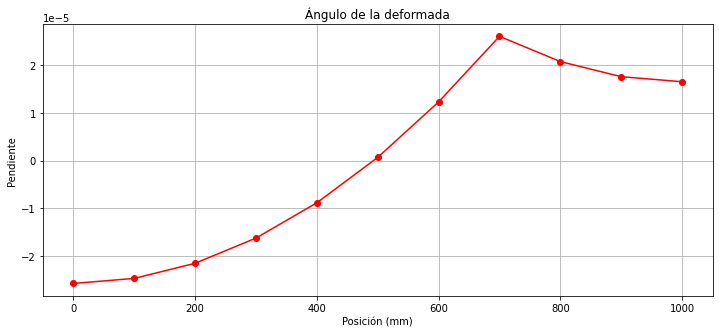

In [401]:
_angle10 = []
for i in range(int(U.shape[0]/2)):
    _angle10.append(U[2*i+1][0])
plt.figure(figsize=(12,5))
plt.grid(True)
plt.title('Ángulo de la deformada')
plt.ylabel('Pendiente')
plt.xlabel('Posición (mm)')
plt.plot(np.linspace(0,1000,10+1),_angle10,'-ro')
#plt.savefig(path+'angle10.pdf')

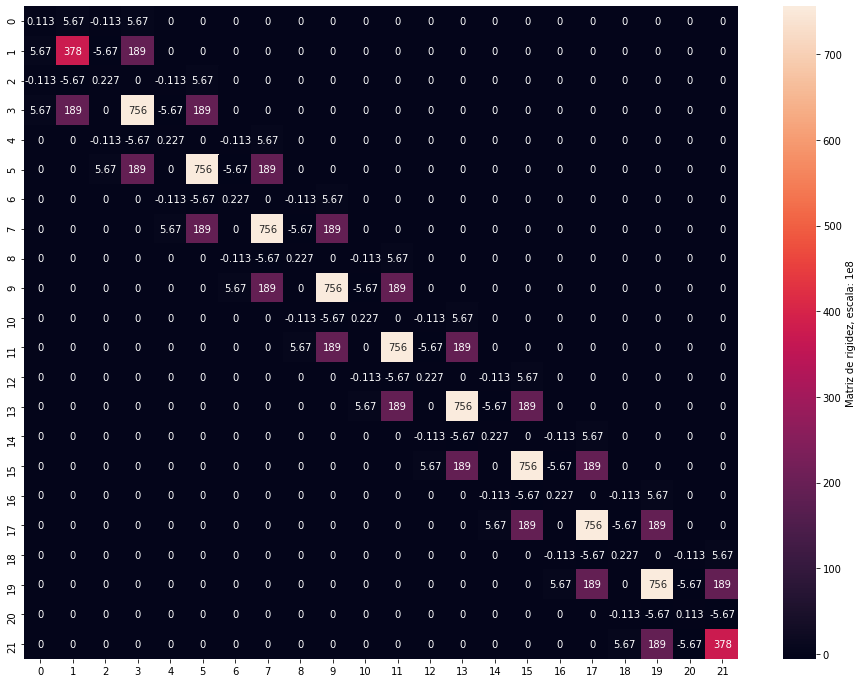

In [402]:
plt.figure(figsize=(16,12))
sns.heatmap(np.around(StiffnessMatrix/1e8,3),fmt='.3g',annot=True,cbar_kws={'label':'Matriz de rigidez, escala: 1e8'})
#plt.savefig(path+'stiffness.pdf')

# Have fun with 1000 elements :p

In [403]:
NodesCondition = []
Nodes = 1001
Nodes *= 2
NumberOfElement = 1000

E = 3e5 #MPA
K = []
I = 315e4 #mm^4
M_A = 2e5 #N-mm
PosNodes = np.arange(0,1000+1,1)
Elements = []
for i in range(0,1000):
    Elements.append((i,i+1))
Elements = np.array(Elements)

L = []
for i in range(NumberOfElement):
    L.append(PosNodes[Elements[i][1]] - PosNodes[Elements[i][0]])
L = np.array(L)

for i in range(0,NumberOfElement):
    aux = ElementStiffness(E,I,L[i])
    K.append(aux)


StiffnessMatrix = np.zeros((Nodes,Nodes))

U = np.zeros(Nodes).reshape(Nodes,1)
F = np.zeros(Nodes).reshape(Nodes,1)

Initialize(StiffnessMatrix,U,F)

#Node in UBoundary = Node*2+(y=0,phi=1)
UBoundaryCondition(U,0,2*0+0) #Nodo 0 en Y
UBoundaryCondition(U,0,2*1000+0) #Nodo 100 en Y

#DFBC(F,w,element)
#FBC(F,f,Node*2+(y=0,phi=1))
FBoundaryCondition(F,M_A,2*700+1) #Momento en el nodo 70


U,F=Solve(StiffnessMatrix,U,F)
print("Stiffness Matrix:\n",StiffnessMatrix,'\n')
print("Displacements:\n",U,'\n')
print("Forces:\n",F)

Stiffness Matrix:
 [[ 1.134e+13  5.670e+12 -1.134e+13 ...  0.000e+00  0.000e+00  0.000e+00]
 [ 5.670e+12  3.780e+12 -5.670e+12 ...  0.000e+00  0.000e+00  0.000e+00]
 [-1.134e+13 -5.670e+12  2.268e+13 ...  0.000e+00  0.000e+00  0.000e+00]
 ...
 [ 0.000e+00  0.000e+00  0.000e+00 ...  7.560e+12 -5.670e+12  1.890e+12]
 [ 0.000e+00  0.000e+00  0.000e+00 ... -5.670e+12  1.134e+13 -5.670e+12]
 [ 0.000e+00  0.000e+00  0.000e+00 ...  1.890e+12 -5.670e+12  3.780e+12]] 

Displacements:
 [[ 0.00000000e+00]
 [-2.57495600e-05]
 [-2.57495248e-05]
 ...
 [ 1.65785889e-05]
 [ 0.00000000e+00]
 [ 1.65784831e-05]] 

Forces:
 [[ 2.00000047e+02]
 [-1.49011612e-07]
 [ 9.14405973e-09]
 ...
 [ 1.86264515e-08]
 [-2.00000008e+02]
 [ 7.45058060e-09]]


In [404]:
_ydisplacements = []
for i in range(int(U.shape[0]/2)):
    _ydisplacements.append(U[2*i][0])

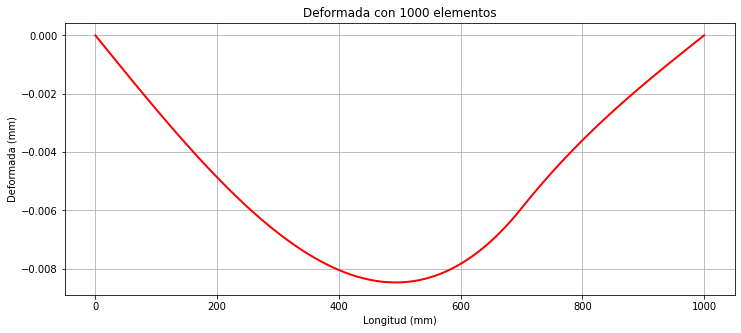

In [405]:
plt.figure(figsize=(12,5))
plt.grid(True)
plt.title('Deformada con 1000 elementos')
plt.xlabel('Longitud (mm)')
plt.ylabel('Deformada (mm)')
plt.plot(_ydisplacements,'-r',linewidth=2)
#plt.savefig(path+'displacements1000.pdf')

In [406]:
C2 = 32.2
A = 20*180
steps_by_element = 100
Stress_S = E*np.ones((NumberOfElement,steps_by_element+1))
Stress_T = 6*E*I*np.ones((1,NumberOfElement))/A
for i in range(NumberOfElement):
    inp = Elements[i][0]
    out = Elements[i][1]
    Stress_T[0][i] = Stress_T[0][i]*(2*U[2*inp][0]+L[i]*U[2*inp+1][0]-2*U[2*out][0]+L[i]*U[2*out+1][0])/(L[i]*L[i]*L[i])
    dx = 2/steps_by_element
    for j in range(0,steps_by_element+1):
        xi = -1+dx*j
        Stress_S[i][j] = Stress_S[i][j]*(6*xi*U[2*inp][0]+(3*xi-1)*L[i]*U[2*inp+1][0]-6*xi*U[2*out][0]+(3*xi+1)*L[i]*U[2*out+1][0])/(L[i]*L[i])

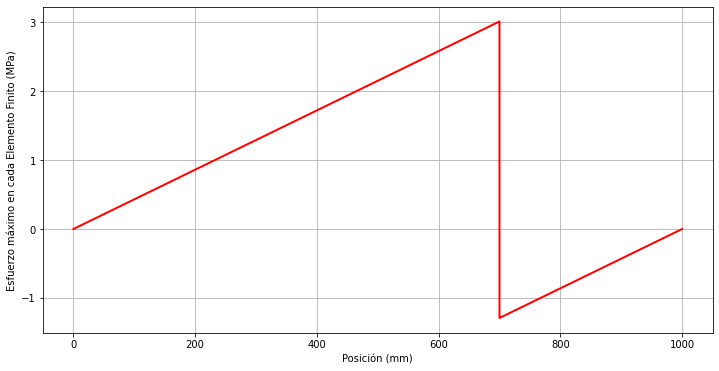

In [407]:
All_Stress = []
for i in range(0,Stress_S.shape[0]):
    for j in range(0,Stress_S.shape[1]):
        All_Stress.append(Stress_S[i][j])
All_Stress = np.array(All_Stress)
plt.figure(figsize=(12,6))
plt.grid(True)
plt.xlabel('Posición (mm)')
plt.ylabel('Esfuerzo máximo en cada Elemento Finito (MPa)')
plt.plot(np.linspace(0,1000,(NumberOfElement+10)*100),(100-C2)*All_Stress,'-r',linewidth=2)
#plt.savefig(path+'stressT.pdf')

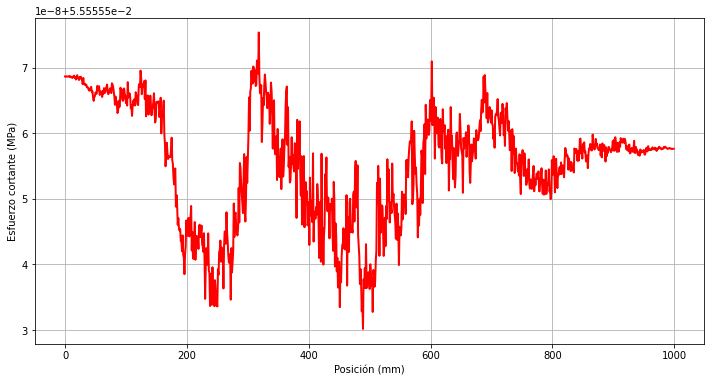

In [408]:
plt.figure(figsize=(12,6))
plt.grid(True)
plt.xlabel(r'Posición (mm)')
plt.ylabel(r'Esfuerzo cortante (MPa)')
plt.plot(Stress_T[0],'-r',linewidth=2)
#plt.savefig(path+'stressC1.pdf')

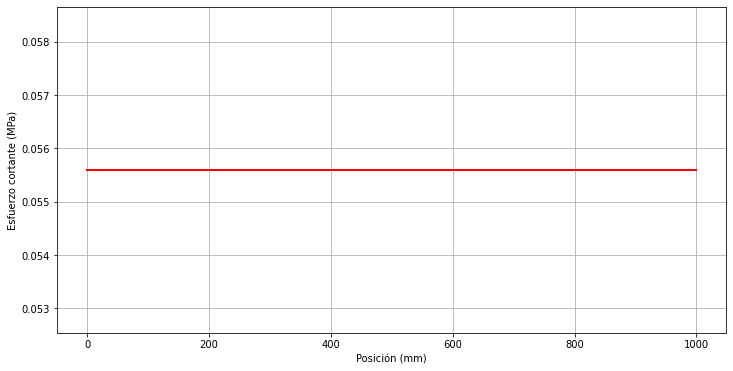

In [409]:
plt.figure(figsize=(12,6))
plt.grid(True)
plt.xlabel(r'Posición (mm)')
plt.ylabel(r'Esfuerzo cortante (MPa)')
plt.plot(np.around(Stress_T[0],4),'-r',linewidth=2)
#plt.savefig(path+'stressC.pdf')

# Diferencias finitas con 10 elementos
## Reacciones

In [410]:
R2 = -200
R1 = 200
E = 3*10**5

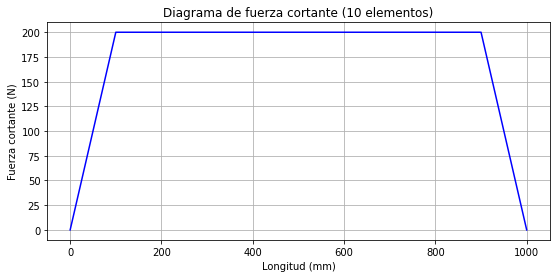

In [411]:
v = []
v.append(0)
for x in range(1,10+1):
    aux = R1
    if x*100 >= 1000:
        aux = 0
    v.append(aux)
    
plt.figure(figsize=(9,4))
plt.title('Diagrama de fuerza cortante (10 elementos)')
plt.xlabel('Longitud (mm)')
plt.ylabel('Fuerza cortante (N)')
plt.grid()
plt.plot(np.linspace(0,1000,10+1),v,'-b')
#plt.savefig('Fuerzacortante.pdf')

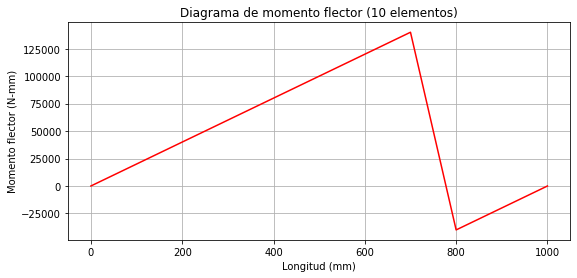

In [412]:
m = []
for x in range(0,10+1):
    aux = R1*x*100
    if x*100>700:
        aux -= M_A
    if x*100>=1000:
        aux += aux + R2*(x*100-(1000))
    m.append(aux)
   
plt.figure(figsize=(9,4))
plt.grid()
plt.title('Diagrama de momento flector (10 elementos)')
plt.xlabel('Longitud (mm)')
plt.ylabel('Momento flector (N-mm)')
plt.plot(np.linspace(0,1000,10+1),m,'r')
#plt.savefig('momento.pdf')

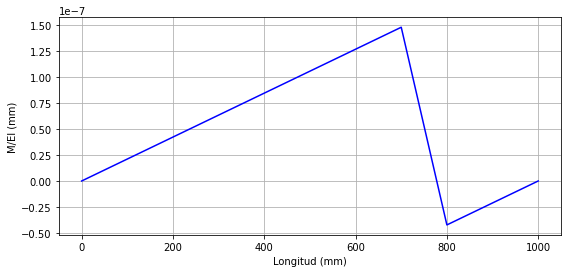

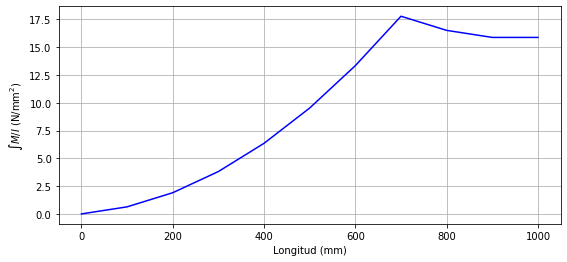

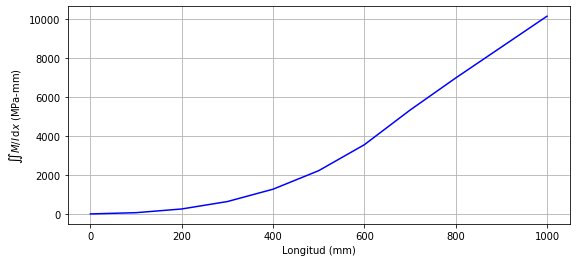

In [413]:
MEI = []
for i in range(0,10+1):
    MEI.append(m[i]/(E*I))
plt.figure(figsize=(9,4))
plt.grid()
plt.xlabel('Longitud (mm)')
plt.ylabel('M/EI (mm)')
plt.plot(np.linspace(0,1000,10+1),MEI,'-b')
#plt.savefig('mei.pdf')


mi = []
mi.append(0)
for i in range(1,10+1):
    mi.append(100*m[i]/I + mi[i-1])
plt.figure(figsize=(9,4))
plt.xlabel('Longitud (mm)')
plt.ylabel('$\int M/I$ (N/mm$^{2}$)')
plt.grid()
plt.plot(np.linspace(0,1000,10+1),mi,'-b')
#plt.savefig('mintegr.pdf')

mii = []
mii.append(0)
for i in range(1,10+1):
    mii.append(100*mi[i]+mii[i-1])
plt.figure(figsize=(9,4))
plt.grid()
plt.xlabel('Longitud (mm)')
plt.ylabel('$ \iint M/I\,\mathrm{d}x $ (MPa-mm)')
plt.plot(np.linspace(0,1000,10+1),mii,'-b')
#plt.savefig('m2i.pdf')

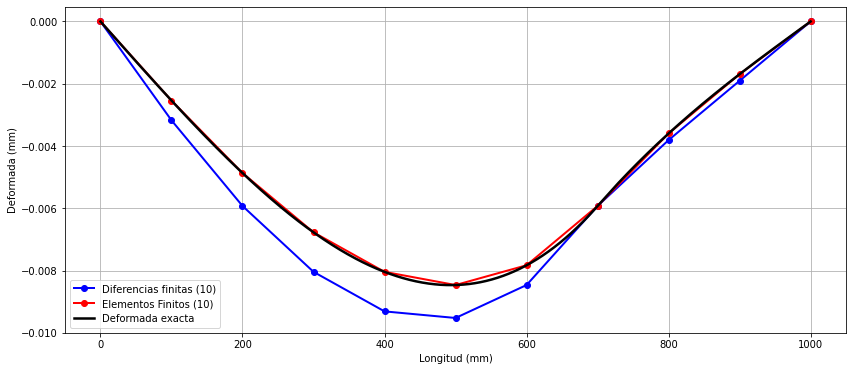

In [414]:
const = -mii[10]/(10)
_ydef10 = []
for i in range(0,10+1):
    _ydef10.append((mii[i]+const*i)/E)

plt.figure(figsize=(14,6))
plt.grid()
plt.xlabel('Longitud (mm)')
plt.ylabel('Deformada (mm)')
plt.plot(np.linspace(0,1000,10+1),_ydef10,'-bo',linewidth=2)
plt.plot(np.linspace(0,1000,10+1),_ydisplacements10,'-ro',linewidth=2)
plt.plot(_ydisplacements,'-k',linewidth=2.5)
plt.legend(['Diferencias finitas (10)','Elementos Finitos (10)','Deformada exacta'])
#plt.savefig(path+'comparision.pdf')

# Solve with many elements

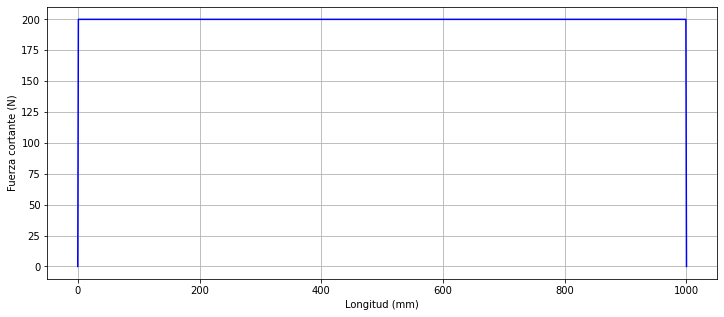

In [415]:
v = []
v.append(0)
for x in range(1,1000+1):
    aux = R1
    if x >= 1000:
        aux = 0
    v.append(aux)
    
plt.figure(figsize=(12,5))
plt.xlabel('Longitud (mm)')
plt.ylabel('Fuerza cortante (N)')
plt.grid()
plt.plot(v,'-b')
#plt.savefig(path+'dv.pdf')

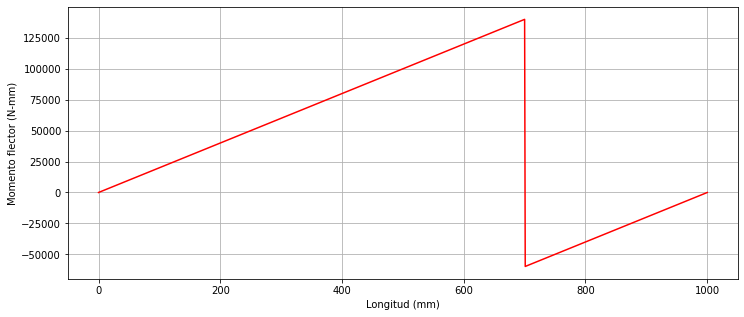

In [416]:
m = []
for x in range(0,1000+1):
    aux = R1*x
    if x>700:
        aux -= M_A
    if x>=1000:
        aux += aux + R2*(x-(1000))
    m.append(aux)
   
plt.figure(figsize=(12,5))
plt.grid()
plt.xlabel('Longitud (mm)')
plt.ylabel('Momento flector (N-mm)')
plt.plot(m,'r')
#plt.savefig(path+'dm.pdf')

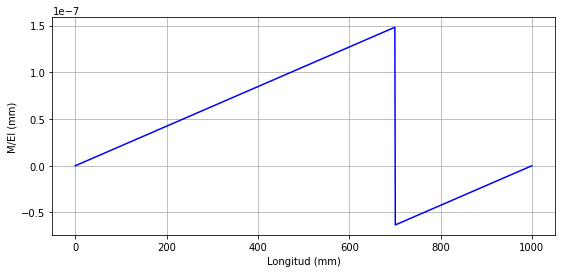

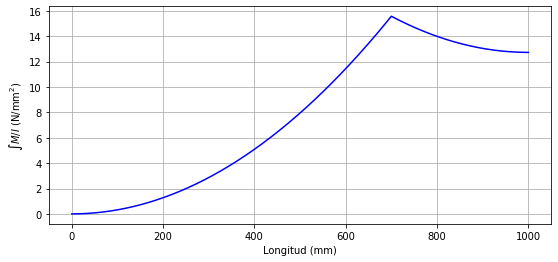

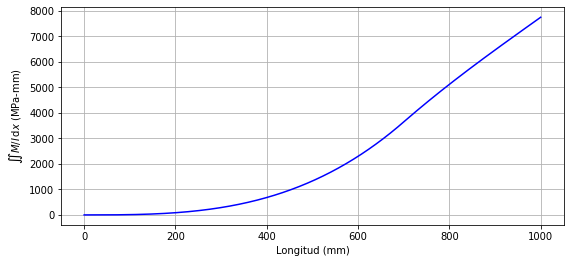

In [417]:
MEI = []
for i in range(0,1000+1):
    MEI.append(m[i]/(E*I))
plt.figure(figsize=(9,4))
plt.grid()
plt.xlabel('Longitud (mm)')
plt.ylabel('M/EI (mm)')
plt.plot(MEI,'-b')
#plt.savefig(path+'mei.pdf')


mi = []
mi.append(0)
for i in range(1,1000+1):
    mi.append(m[i]/I + mi[i-1])
plt.figure(figsize=(9,4))
plt.xlabel('Longitud (mm)')
plt.ylabel('$\int M/I$ (N/mm$^{2}$)')
plt.grid()
plt.plot(mi,'-b')
#plt.savefig(path+'mi.pdf')

mii = []
mii.append(0)
for i in range(1,1000+1):
    mii.append(mi[i]+mii[i-1])
plt.figure(figsize=(9,4))
plt.grid()
plt.xlabel('Longitud (mm)')
plt.ylabel('$ \iint M/I\,\mathrm{d}x $ (MPa-mm)')
plt.plot(mii,'-b')
#plt.savefig(path+'mii.pdf')

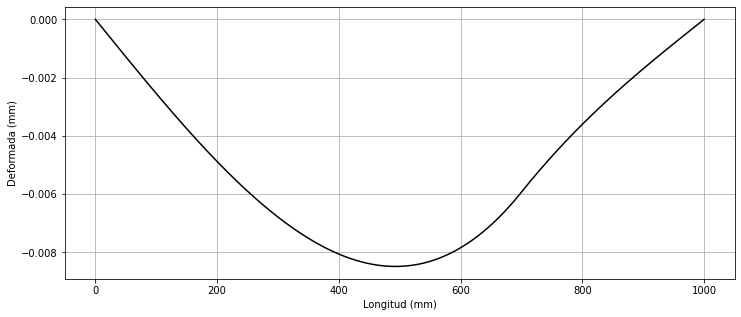

In [418]:
const = -mii[1000]/(1000)
_ydef1000 = []
for i in range(0,1000+1):
    _ydef1000.append((mii[i]+const*i)/E)
plt.figure(figsize=(12,5))
plt.grid()
plt.xlabel('Longitud (mm)')
plt.ylabel('Deformada (mm)')
plt.plot(_ydef1000,'-k')
#plt.savefig(path+'deformada1000.pdf')

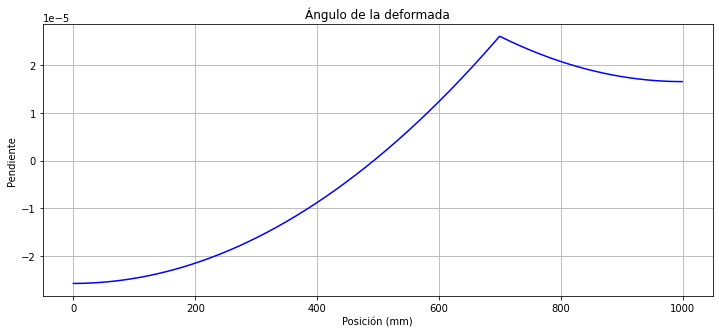

In [419]:
_angle = []
for i in range(0,1000):
    _angle.append((_ydisplacements[i+1]-_ydisplacements[i]))
plt.figure(figsize=(12,5))
plt.grid()
plt.title('Ángulo de la deformada')
plt.ylabel('Pendiente')
plt.xlabel('Posición (mm)')
plt.plot(_angle,'-b')
#plt.savefig(path+'angle1000.pdf')

0.008478765291005294 493
Esfuerzo máximo = 3.013333333333333 MPa en la posición 700
Esfuerzo máximo combinado = 3.0138454169931914 MPa en la posición 700


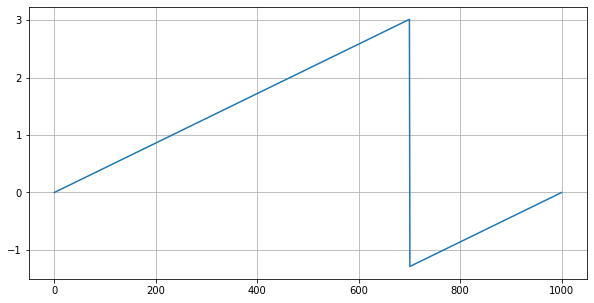

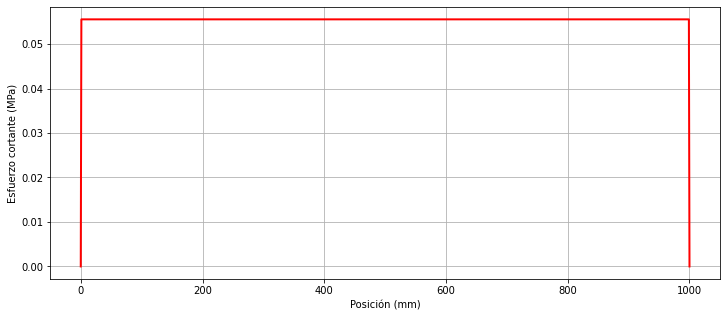

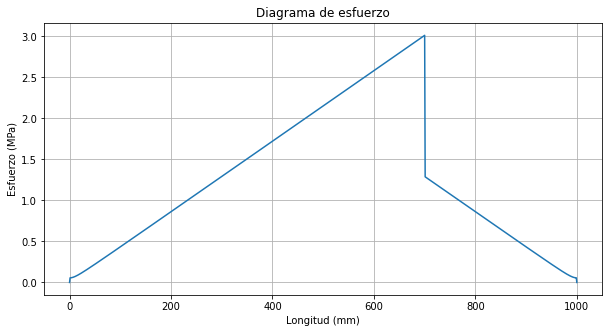

In [420]:
import math
plt.figure(figsize=(10,5))
plt.grid()
flechamax = 0
posflecha = 0
for i in range(0,1000+1):
    if flechamax < abs(_ydef1000[i]):
        flechamax = abs(_ydef1000[i])
        posflecha = i
print(abs(flechamax),posflecha)


esfm = 0
poses = 0
_S1000 = []
for i in range(0,1000+1):
    _S1000.append((100-C2)*m[i]/I)
    if abs((100-C2)*m[i]/I) > esfm:
        esfm = abs((100-C2)*m[i]/I)
        poses = i
plt.plot(_S1000)

print("Esfuerzo máximo = "+str(esfm)+" MPa en la posición " + str(poses))
#MPa
_V1000 = []
for i in range(0,1000+1):
    _V1000.append(v[i]/A)
plt.figure(figsize=(12,5))
plt.grid()
plt.xlabel(r'Posición (mm)')
plt.ylabel(r'Esfuerzo cortante (MPa)')
plt.plot(_V1000,'-r',linewidth=2)
#plt.savefig(path+'stressC.pdf')

esfm = 0
poses = 0
gresf = []
for i in range(0,1000+1):
    esfS = abs(_S1000[i])
    esfT = abs(_V1000[i])
    gresf.append(math.sqrt(esfS**2 + esfT**2))
    if math.sqrt(esfS**2 + esfT**2) > esfm:
        esfm = math.sqrt(esfS**2 + esfT**2)
        poses = i

print("Esfuerzo máximo combinado = "+str(esfm)+" MPa en la posición " + str(poses))

plt.figure(figsize=(10,5))
plt.grid()
plt.title('Diagrama de esfuerzo')
plt.xlabel('Longitud (mm)')
plt.ylabel('Esfuerzo (MPa)')
plt.plot(gresf)
#plt.savefig('esfuerzo.pdf')